# Import packages

In [1]:
from lazy5.inspect import get_groups
from lazy5.inspect import get_datasets
from lazy5.inspect import get_hierarchy
from lazy5.inspect import get_attrs_dset
import h5py

import numpy as np
from numpy import genfromtxt
from numpy import unravel_index
import matplotlib.pyplot as plt


from matplotlib.widgets import Slider
from IPython.display import display
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


from copy import deepcopy
from spectral import *
from sklearn import preprocessing

from datetime import datetime

from sklearn.utils import shuffle
from IPython.display import display

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Define general used functions

In [2]:
def find_nearest_wn(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_pix(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Lazy5 to read file structure

In [3]:
filename = 'N2_1DAD_02_PROCESS_2018103_11_27_58_192221.h5'
fid = h5py.File(filename, 'r')

dset_list = get_datasets(fid)

print('Datasets:')
for dset in dset_list:
    print(dset)

fid.close()

Datasets:
BCARSImage/01_2/01_2_SubDark_Anscombe_SVD_InvAnscombe_MergeNRBs_KK_PhaseErrorCorrectALS_ScaleErrorCorrectSG


In [4]:
dsetname = 'BCARSImage/01_2/01_2_SubDark_Anscombe_SVD_InvAnscombe_MergeNRBs_KK_PhaseErrorCorrectALS_ScaleErrorCorrectSG'

attr_dict = get_attrs_dset(filename, dsetname)

print('Dataset Attributes:')
for k in attr_dict:
    print('{} : {}'.format(k, attr_dict[k]))

# To read data

In [5]:
d = h5py.File(filename, 'r')
dset = d[dsetname]

In [6]:
pix = np.arange(attr_dict['Spectro.SpectralPixels'])  # Pixel vector
wl0 = np.polyval(attr_dict['Calib.a_vec'], pix) + attr_dict['Calib.ctr_wl'] - attr_dict['Calib.ctr_wl0'] # Wavelength in nm
wn0 = 0.01 / (1e-9*wl0) - 0.01 / (attr_dict['Calib.probe']*1e-9)

rng=dset.attrs['Processing.Steps.8.PhaseErrorCorrectALS.rng'] # Check the right attributes

# Wavenumber calibration (Histogram of peaks locating between 950 - 1050)

In [7]:
cali_wn_min = 950    #indicate the min wn of calibration range (cm-1)
cali_wn_max = 1050   #indicate the max wn of calibration range (cm-1)
phe_peak = 1002       #indicate the wavenumber of Phe peak

y_dim, x_dim, z_dim = dset.shape
phe_range=np.arange(find_nearest_pix(wn0, cali_wn_min),find_nearest_pix(wn0, cali_wn_max))
phe_wn_range = wn0[phe_range]
phe_wn_his = []
phe_pix_his = []

start_time = datetime.now()

for i in range(x_dim):
    for j in range(y_dim):
        phe_pix_his.append(np.argmax(dset[j,i,phe_range].imag))
    if (((i*100/(x_dim))/10) >= 1 and ((i*100/(x_dim)) % 10)==0):
        print(i*100/(x_dim), '%')
            
print('100.0 %')
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
Duration: 0:01:59.086288


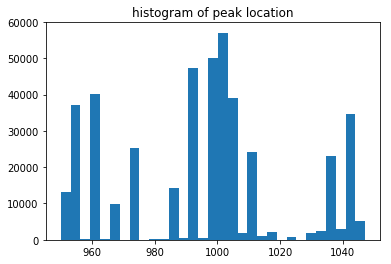

measured phe peak: 1000.1681674930376  cm-1
calibrated wavenumber for Phe peak: 1002.0 cm-1


In [8]:
phe_wn_his = phe_wn_range[phe_pix_his]
y, x, _ = plt.hist(phe_wn_his, bins=len(phe_range))
plt.title('histogram of peak location')
plt.show()

measured_phe_wn = np.average(x[(np.where(y == y.max()))])
print('measured phe peak:', measured_phe_wn, ' cm-1')

shift = phe_peak - find_nearest_wn(wn0, measured_phe_wn)

# apply the shift
wn = wn0 + shift
wn_rng = wn[rng]

print('calibrated wavenumber for Phe peak:', find_nearest_wn(wn, phe_peak), 'cm-1')

# find the pixel with highest phe signal
(phe_max_y, phe_max_x) = unravel_index(dset[:,:,find_nearest_pix(wn, phe_peak)].imag.argmax(), dset[:,:,find_nearest_pix(wn, phe_peak)].imag.shape)

# Data visualization

In [9]:
def f0(x):
    plt.imshow(dset[:,:,x].imag, origin='lower')
    plt.colorbar()
    plt.show()
    print ('wavenumber = ', wn[x], 'cm-1')
    print ('index: ', x)

phe_idx = find_nearest_pix(wn, phe_peak)
lipid_idx = find_nearest_pix(wn, 2850)
lipid_protein_idx = find_nearest_pix(wn, 2925)

interact(f0, x=[('Phe', phe_idx), ('lipid(CH2)', lipid_idx), ('protein_lipid(CH3)', lipid_protein_idx)])

<function __main__.f0>

In [10]:
y_dim, x_dim, z_dim = dset.shape

a = widgets.IntSlider(min=np.min(rng), max=np.max(rng), step=1, value=find_nearest_pix(wn, phe_peak))
x_min = widgets.IntSlider(min=0, max=x_dim, step=1, value=0)
x_max = widgets.IntSlider(min=0, max=x_dim, step=1, value=x_dim)
y_min = widgets.IntSlider(min=0, max=y_dim, step=1, value=0)
y_max = widgets.IntSlider(min=0, max=y_dim, step=1, value=y_dim)

ui = widgets.HBox([a, x_min, x_max, y_min, y_max])

def f(a, x_min, x_max, y_min, y_max):
    plt.imshow(dset[y_min:y_max,x_min:x_max,a].imag, extent=[x_min,x_max, y_min,y_max], origin='lower', aspect='auto')
    plt.colorbar()
    plt.show()
    print ('wavenumber = ', wn[a], 'cm-1')

def update_x_max(*args):
    x_max.min = x_min.value +1
x_max.observe(update_x_max, 'value')

def update_x_min(*args):
    x_min.max = x_max.value -1
x_min.observe(update_x_min, 'value')

def update_y_max(*args):
    y_max.min = y_min.value +1
y_max.observe(update_y_max, 'value')

def update_y_min(*args):
    y_min.max = y_max.value -1
y_min.observe(update_y_min, 'value')


out = widgets.interactive_output(f, {'a': a, 'x_min':x_min, 'x_max':x_max, 'y_min':y_min, 'y_max':y_max})

display(ui, out)

In [11]:
# The spectrum shows the pixel with maximum phe signal
x_point = widgets.IntSlider(min=0, max=x_dim, step=1, value=phe_max_x)
y_point = widgets.IntSlider(min=0, max=y_dim, step=1, value=phe_max_y)

pix_min = widgets.IntSlider(min=np.min(rng), max=np.max(rng), step=1, value=np.min(rng))
pix_max = widgets.IntSlider(min=np.min(rng), max=np.max(rng), step=1, value=np.max(rng))
intensity_min = widgets.FloatSlider(min=-0.1, max=3.000, step=0.005, value=-0.1)
intensity_max = widgets.FloatSlider(min=-0.1, max=3.000, step=0.005, value=3.000)

def update_pix_max(*args):
    pix_max.min = pix_min.value + 1
pix_max.observe(update_pix_max, 'value')

def update_pix_min(*args):
    pix_min.max = pix_max.value - 1
pix_min.observe(update_pix_min, 'value')

def update_intensity_max(*args):
    intensity_max.min = intensity_min.value + 0.005
intensity_max.observe(update_intensity_max, 'value')

def update_intensity_min(*args):
    intensity_min.max = intensity_max.value - 0.005
intensity_min.observe(update_intensity_min, 'value')

def spec(x_point, y_point, pix_min, pix_max, intensity_min, intensity_max):
    updated_wn_rng = wn[pix_min:pix_max]
    plt.plot(updated_wn_rng, dset[y_point, x_point , pix_min:pix_max].imag)
    plt.ylim(intensity_min,intensity_max)
    plt.grid(True)
    plt.show()

interact(spec,x_point=x_point, y_point=y_point, pix_min=pix_min, pix_max=pix_max, intensity_min=intensity_min, intensity_max=intensity_max)

<function __main__.spec>

# Optional: Remove Raman silent Region (1850 - 2750 cm-1)

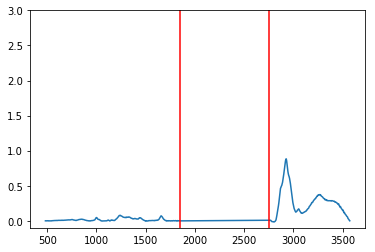

spectrum points from  839  reduced to  605


In [12]:
x = phe_max_x
y = phe_max_y

idx_silent_left = find_nearest_pix(wn, 1850)
idx_silent_right = find_nearest_pix(wn, 2750)
silent_rng = np.arange(idx_silent_left, idx_silent_right+1)
nonsilent_rng = np.setdiff1d(rng,silent_rng)
nonsilent_wn_rng = wn[nonsilent_rng]

plt.plot(nonsilent_wn_rng, dset[y, x , nonsilent_rng].imag)
plt.plot([wn[find_nearest_pix(wn, 1850)], wn[find_nearest_pix(wn, 1850)]], [-0.1,3], color='r')
plt.plot([wn[find_nearest_pix(wn, 2750)], wn[find_nearest_pix(wn, 2750)]], [-0.1,3], color='r')
plt.ylim(-0.1,3)
plt.show()

print('spectrum points from ', len(wn_rng), ' reduced to ', len(nonsilent_wn_rng))

# nonilent_rng for the pixel vector; nonsilent_wn_rng for the wavenumber vector

# Copy data for analysis

In [13]:
analysis_rng = nonsilent_rng           # To define the analyssi pixel range: nonsilent region (nonsilent_rng) or whole (rng)
analysis_wn_rng = nonsilent_wn_rng     # To define the analyssi wn range: nonsilent region (nonsilent_wn_rng) or whole (wn_rng)


start_time0 = datetime.now()

X = deepcopy(dset[: , : , analysis_rng].imag)  

end_time0 = datetime.now()
print('Duration: {}'.format(end_time0 - start_time0))

Duration: 0:00:26.567122


# To determine number of clusters by SVD

In [14]:
X_flatten = X.reshape((X.shape[0]*X.shape[1]), X.shape[2])

X_rnd = deepcopy(X_flatten)

U, s, V = np.linalg.svd(X_flatten, full_matrices=False)

S = np.diag(s)

In [15]:
rnd_times = 10  # times of randomization (at different wn), about 30s per single randomization

start_time = datetime.now()

if( np.isclose(X_flatten, U @ S @ V).all() ==True ):
    print(X_flatten.shape, U.shape, S.shape, V.shape, s.shape, X_rnd.shape)
    start_time_loop = datetime.now()
    for j in range(X_rnd.shape[1]):
        np.random.shuffle(X_rnd[:,j])
    U_rnd, s_rnd, V_rnd = np.linalg.svd(X_rnd, full_matrices=False)
    s_rnd_total=s_rnd
    end_time_loop = datetime.now()
    print('Duration for randomization {}/{}: {} (s)'.format(1, rnd_times, end_time_loop - start_time_loop))
    for i in range(rnd_times-1):
        start_time_loop = datetime.now()
        for j in range(X_rnd.shape[1]):
            np.random.shuffle(X_rnd[:,j])
        U_rnd, s_rnd, V_rnd = np.linalg.svd(X_rnd, full_matrices=False)
        s_rnd_total=np.vstack([s_rnd_total, s_rnd])
        end_time_loop = datetime.now()
        print('Duration for randomization {}/{}: {} (s)'.format(i+2, rnd_times, end_time_loop - start_time_loop))
         
    s_rnd_sd=s_rnd_total.std(axis=0)
    s_rnd_mean=s_rnd_total.mean(axis=0)
    s_nor=s/s.sum()
    s_rnd_mean_nor=s_rnd_mean/s_rnd_mean.sum()
    s_rnd_sd_nor=s_rnd_sd/s_rnd_mean.sum()
    
end_time = datetime.now()
print('Total duration: {}'.format(end_time - start_time))

(435600, 605) (435600, 605) (605, 605) (605, 605) (605,) (435600, 605)
Duration for randomization 1/10: 0:00:29.954079 (s)
Duration for randomization 2/10: 0:00:29.075437 (s)
Duration for randomization 3/10: 0:00:29.029546 (s)
Duration for randomization 4/10: 0:00:28.992649 (s)
Duration for randomization 5/10: 0:00:29.113300 (s)
Duration for randomization 6/10: 0:00:29.280916 (s)
Duration for randomization 7/10: 0:00:29.138272 (s)
Duration for randomization 8/10: 0:00:29.125311 (s)
Duration for randomization 9/10: 0:00:29.325735 (s)
Duration for randomization 10/10: 0:00:30.054857 (s)
Total duration: 0:05:01.574500


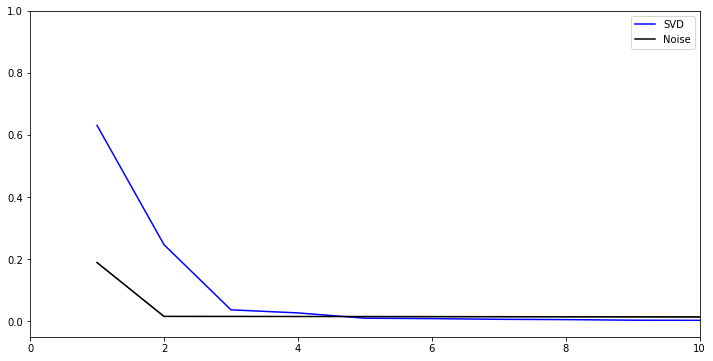

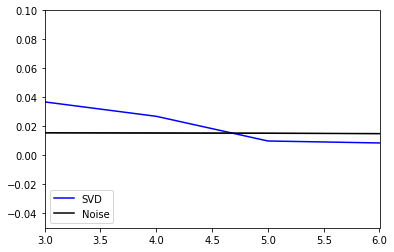

In [16]:
fig = plt.figure(figsize=(12,6))
x_axis = np.arange(1,len(s_nor)+1,1)


plt.plot(x_axis, s_nor, color='blue')
plt.plot(x_axis, s_rnd_mean_nor, color='black')
plt.fill_between(x_axis, s_rnd_mean_nor + s_rnd_sd_nor, s_rnd_mean_nor - s_rnd_sd_nor, color='grey')
plt.axis((0,10,-0.05,1))
plt.legend(('SVD','Noise'))
# plt.savefig('SVD_01.png')
plt.show()


plt.plot(x_axis, s_nor, color='blue')
plt.plot(x_axis, s_rnd_mean_nor, color='black')
plt.fill_between(x_axis, s_rnd_mean_nor + s_rnd_sd_nor, s_rnd_mean_nor - s_rnd_sd_nor, color='grey')
plt.axis((3,6,-0.05,0.1))
plt.legend(('SVD','Noise'))
# plt.savefig('SVD_02.png')
plt.show()

# K-means clustering

In [17]:
clusters = 4

from datetime import datetime
start_time = datetime.now()

(m, c) = kmeans(X, clusters, 50)  #kmeans(data, #_of_clusters, iterations)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

print('{} clusters have been found'.format(c.shape[0]))
clusters = c.shape[0]

spectral:INFO: k-means iteration 1 - 36324 pixels reassigned.
spectral:INFO: k-means iteration 2 - 15411 pixels reassigned.
spectral:INFO: k-means iteration 3 - 20497 pixels reassigned.
spectral:INFO: k-means iteration 4 - 19156 pixels reassigned.
spectral:INFO: k-means iteration 5 - 13103 pixels reassigned.
spectral:INFO: k-means iteration 6 - 7351 pixels reassigned.
spectral:INFO: k-means iteration 7 - 4394 pixels reassigned.
spectral:INFO: k-means iteration 8 - 2889 pixels reassigned.
spectral:INFO: k-means iteration 9 - 2253 pixels reassigned.
spectral:INFO: k-means iteration 10 - 2084 pixels reassigned.
spectral:INFO: k-means iteration 11 - 1943 pixels reassigned.
spectral:INFO: k-means iteration 12 - 1894 pixels reassigned.
spectral:INFO: k-means iteration 13 - 1755 pixels reassigned.
spectral:INFO: k-means iteration 14 - 1508 pixels reassigned.
spectral:INFO: k-means iteration 15 - 1295 pixels reassigned.
spectral:INFO: k-means iteration 16 - 1033 pixels reassigned.
spectral:INF

Duration: 0:02:10.123560
4 clusters have been found


In [18]:
#Display the clustered results
x_clustered_min = widgets.IntSlider(min=0, max=x_dim, step=1, value=0, description='clustered x_min')
x_clustered_max = widgets.IntSlider(min=0, max=x_dim, step=1, value=x_dim, description='clustered x_max')
y_clustered_min = widgets.IntSlider(min=0, max=y_dim, step=1, value=0, description='clustered y_min')
y_clustered_max = widgets.IntSlider(min=0, max=y_dim, step=1, value=y_dim, description='clustered y_max')

ui_clustered = widgets.HBox([x_clustered_min, x_clustered_max, y_clustered_min, y_clustered_max])

def f_clustered(x_clustered_min, x_clustered_max, y_clustered_min, y_clustered_max):
    print ('clusters = ', c.shape[0], '(k-means)')
    plt.imshow(m[y_clustered_min:y_clustered_max,x_clustered_min:x_clustered_max], extent=[x_clustered_min,x_clustered_max, y_clustered_min,y_clustered_max], origin='lower', cmap='jet', aspect='auto')
    plt.colorbar()
    plt.show()
    

def update_x_clustered_max(*args):
    x_clustered_max.min = x_clustered_min.value +1
x_clustered_max.observe(update_x_clustered_max, 'value')

def update_x_clustered_min(*args):
    x_clustered_min.max = x_clustered_max.value -1
x_clustered_min.observe(update_x_clustered_min, 'value')

def update_y_clustered_max(*args):
    y_clustered_max.min = y_clustered_min.value +1
y_clustered_max.observe(update_y_clustered_max, 'value')

def update_y_clustered_min(*args):
    y_clustered_min.max = y_clustered_max.value -1
y_clustered_min.observe(update_y_clustered_min, 'value')


out_clustered = widgets.interactive_output(f_clustered, {'x_clustered_min':x_clustered_min, 'x_clustered_max':x_clustered_max, 'y_clustered_min':y_clustered_min, 'y_clustered_max':y_clustered_max})

display(ui_clustered, out_clustered)




#To compare (original)
out = widgets.interactive_output(f, {'a': a, 'x_min':x_min, 'x_max':x_max, 'y_min':y_min, 'y_max':y_max})
display(ui, out)


phe_idx = find_nearest_pix(wn, phe_peak)
lipid_idx = find_nearest_pix(wn, 2850)
lipid_protein_idx = find_nearest_pix(wn, 2925)

print ('Phe (1002cm-1): ', phe_idx, '\t', 'lipid (2845cm-1): ', lipid_idx, '\t', 'lipid/protein (2925cm-1): ', lipid_protein_idx)

Phe (1004cm-1):  701 	 lipid (2845cm-1):  1204 	 lipid/protein (2925cm-1):  1222


In [19]:
Target_wn = 2845
print(find_nearest_pix(wn, Target_wn))

1203


# Specta of centroid locations

cluster 0


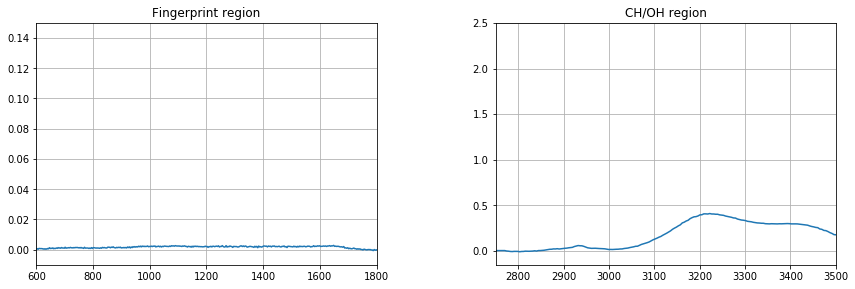



cluster 1


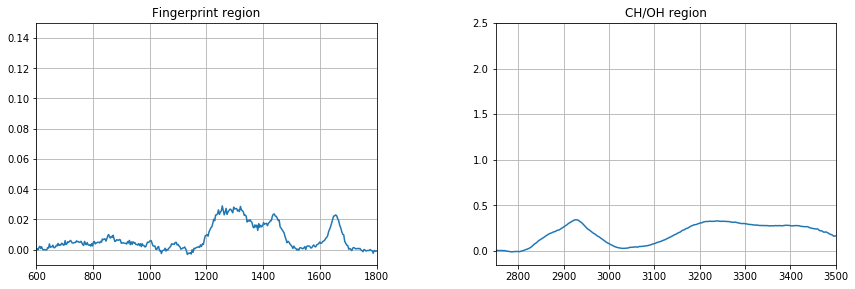



cluster 2


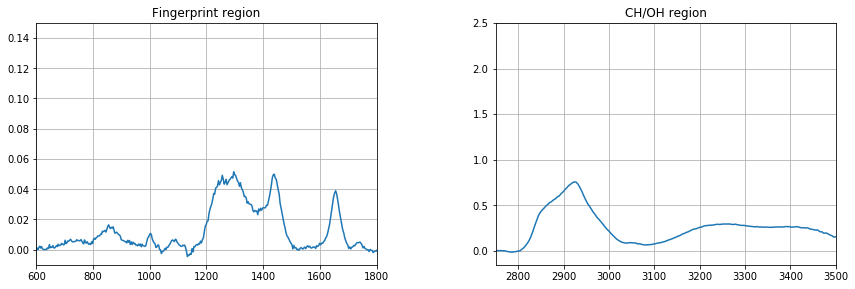



cluster 3


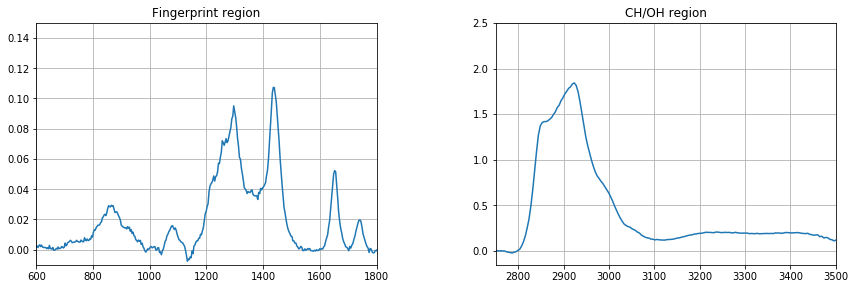

In [20]:
for cluster_num in range(c.shape[0]):
    print('cluster',cluster_num)
    
    plt.figure()
    
    plt.subplot(121)
    plt.plot(analysis_wn_rng, c[cluster_num,:])
    plt.title('Fingerprint region')
    plt.xlim(600,1800)
    plt.ylim(-0.01,0.15)
    plt.grid(True)
    
    plt.subplot(122)
    plt.plot(analysis_wn_rng, c[cluster_num,:])
    plt.title('CH/OH region')
    plt.xlim(2750,3500)
    plt.ylim(-0.15,2.5)
    plt.grid(True)
  
  
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=1.95, hspace=0.3, wspace=0.35)
    
    plt.show()
    print('\n')

# To save figures

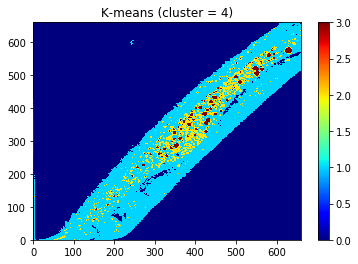

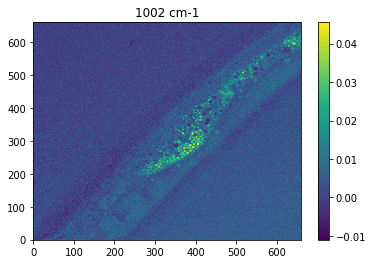

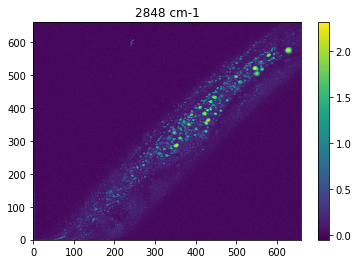

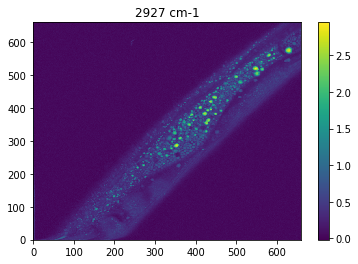

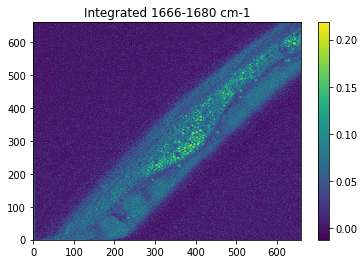

In [21]:
plt.imshow(m[:,:], extent=[0,x_dim, 0,y_dim], origin='lower', cmap='jet', aspect='auto')
plt.title('K-means (cluster = {})'.format(c.shape[0]))
plt.colorbar()
plt.savefig('K-means(cluster= {}).png'.format(c.shape[0]), dpi=300)
plt.show()


#Original images
plt.imshow(dset[:,:,find_nearest_pix(wn, phe_peak)].imag, origin='lower', aspect='auto')
plt.title('{} cm-1'.format(int(find_nearest_wn(wn, phe_peak))))
plt.colorbar()
plt.savefig('{}.png'.format(int(find_nearest_wn(wn, phe_peak))), dpi=300)
plt.show()

plt.imshow(dset[:,:,find_nearest_pix(wn, 2850)].imag, origin='lower', aspect='auto')
plt.title('{} cm-1'.format(int(find_nearest_wn(wn, 2850))))
plt.colorbar()
plt.savefig('{}.png'.format(int(find_nearest_wn(wn, 2850))), dpi=300)
plt.show()

plt.imshow(dset[:,:,find_nearest_pix(wn, 2930)].imag, origin='lower', aspect='auto')
plt.title('{} cm-1'.format(int(find_nearest_wn(wn, 2928))))
plt.colorbar()
plt.savefig('{}.png'.format(int(find_nearest_wn(wn, 2928))), dpi=300)
plt.show()

# To save the image with integrated intensity
Target_wn_min = 1665
Target_wn_max = 1680
plt.imshow(np.sum(dset[:,:,find_nearest_pix(wn, Target_wn_min):find_nearest_pix(wn, Target_wn_max)].imag,axis=2), origin='lower', aspect='auto')
plt.title('Integrated {}-{} cm-1'.format(int(find_nearest_wn(wn, Target_wn_min)), int(find_nearest_wn(wn, Target_wn_max))))
plt.colorbar()
plt.savefig('{}-{}.png'.format(int(find_nearest_wn(wn, Target_wn_min)),int(find_nearest_wn(wn, Target_wn_max))), dpi=300)
plt.show()

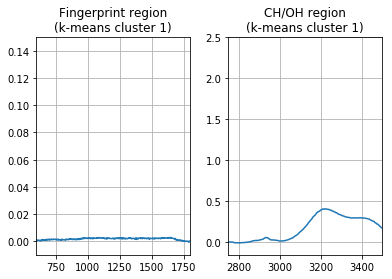

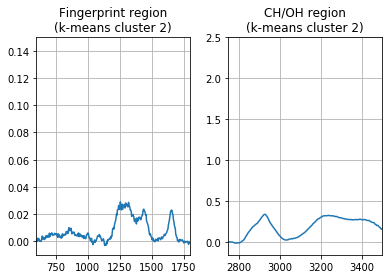

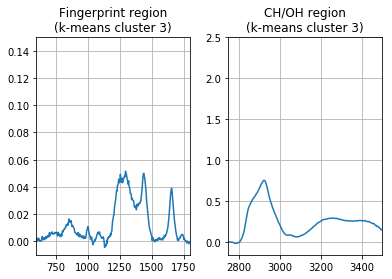

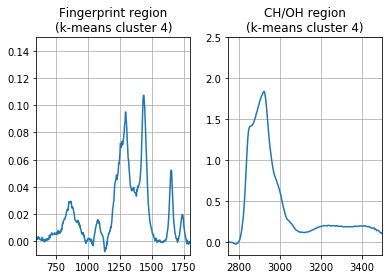

In [22]:
for cluster_num in range(c.shape[0]):
    
    fig = plt.figure()
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(analysis_wn_rng, c[cluster_num,:])
    ax1.set_title('Fingerprint region' '\n' '(k-means cluster {0})'.format(cluster_num))
    ax1.set_xlim(600,1800)
    ax1.set_ylim(-0.01,0.15)
    ax1.grid()
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(analysis_wn_rng, c[cluster_num,:])
    ax2.set_title('CH/OH region' '\n' '(k-means cluster {0})'.format(cluster_num))
    ax2.set_xlim(2750,3500)
    ax2.set_ylim(-0.15,2.5)
    ax2.grid()
    
    fig.subplots_adjust(left=0.1, right=0.9, wspace=0.25)
    
    fig.savefig('Spectum of centroid location (K-means, cluster ={0}).png'.format(cluster_num) , dpi=300)
    plt.show()